    * PyMC3 is a new open source Probabilistic Programming framework written in Python
    * Uses Theano to compute gradients via automatic differentiation as well as compile probabilistic programs on-the-fly to C for increased speed
    * It features next-generation Markov chain Monte Carlo (MCMC, Hamliltonian Monte Carlo,) 
    * a self-tuning variant of Hamiltonian Monte Carlo 
    * works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms
    * No-U-Turn Sampler (NUTS) and Hamiltonian Monte Carlo take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially
      for larger models.

### PyMC3 for solving general Bayesian statistical inference and prediction problems.
    * model definition,
    * model fitting,
    * posterior analysis 

In [1]:
# Installation 
#!conda install theano -y 
#!pip install pymc3
#!pip install patsy


# Generating the Data

In [2]:

import numpy as np
import matplotlib.pyplot as plt

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

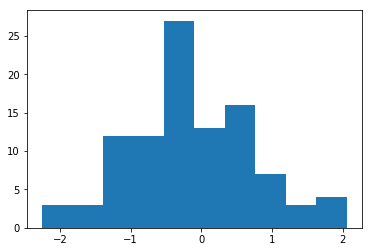

In [3]:
plt.hist(np.random.randn(size))
plt.show()

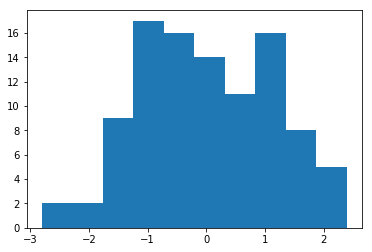

In [4]:
plt.hist(beta[0]*X1 )
plt.show()

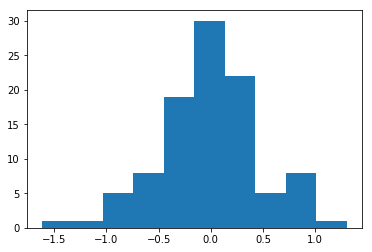

In [5]:
plt.hist(beta[1]*X2 )
plt.show()

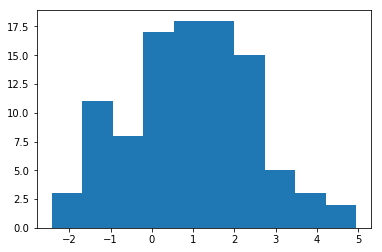

In [6]:
plt.hist(Y )
plt.show()

# Visulizaing the Data


 
 X2 is highly correlated with Y 



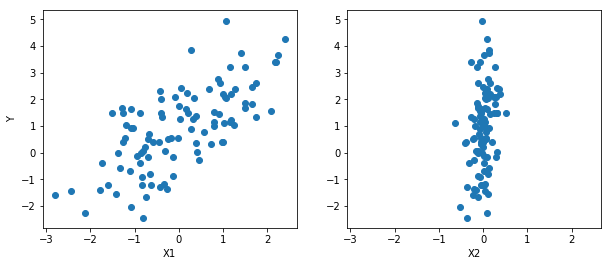

In [7]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True,figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); 
axes[0].set_xlabel('X1'); 
axes[1].set_xlabel('X2');

print ('\n \n X2 is highly correlated with Y \n')

# Model Specification


In [47]:
import pymc3 as pm
basic_model = pm.Model()

# Context Manager of the Model 
with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    #beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    beta = pm.Uniform('beta',lower=0, upper=4, shape=2)

    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

In [48]:
#help(pm.Normal)

# Model fitting
* 1) Maximum a posteriori methods (MAP) :using optimization methods
* 2) Sampling methods: computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods


### MAP

In [49]:
# By default, find_MAP uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also 
# allows selection of other optimization algorithms from the scipy.optimize module.
map_estimate = pm.find_MAP(model=basic_model)

print ('''
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]
''')

map_estimate


logp = -145.68, ||grad|| = 2.5074: 100%|██████████| 20/20 [00:00<00:00, 1083.25it/s] 


# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]



{'alpha': array(0.9066230663309659),
 'beta': array([ 0.94858003,  2.6135602 ]),
 'beta_interval__': array([-1.16839616,  0.63397419]),
 'sigma': array(0.9629870566829105),
 'sigma_log__': array(-0.03771530789436805)}

In [50]:
from scipy import optimize

map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)

map_estimate

/Users/alhaol/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -151:   4%|▍         | 189/5000 [00:00<00:04, 1123.96it/s]

Optimization terminated successfully.
         Current function value: 145.273726
         Iterations: 4
         Function evaluations: 189


{'alpha': array(0.9069921854728327),
 'beta': array([ 0.94828353,  2.61374079]),
 'beta_interval__': array([-1.16880595,  0.63417355]),
 'sigma': array(0.9632798689103829),
 'sigma_log__': array(-0.03741128748490427)}

In [51]:
# Most techniques for finding the MAP estimate also only find a local optimum (which is often good enough), 
# but can fail badly for multimodal posteriors if the different modes are meaningfully different.

### MCMC

* Cons: No associated estimate of uncertainty produced with the MAP estimate

In [52]:
with basic_model:

    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, start=start)

/Users/alhaol/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -151:   4%|▍         | 189/5000 [00:00<00:04, 1111.35it/s]


Optimization terminated successfully.
         Current function value: 145.273726
         Iterations: 4
         Function evaluations: 189


100%|██████████| 5500/5500 [00:17<00:00, 311.19it/s]


(array([   18.,   106.,   376.,   930.,  1386.,  1228.,   676.,   221.,
           51.,     8.]),
 array([ 0.56281153,  0.63423418,  0.70565684,  0.77707949,  0.84850215,
         0.9199248 ,  0.99134746,  1.06277011,  1.13419276,  1.20561542,
         1.27703807]),
 <a list of 10 Patch objects>)

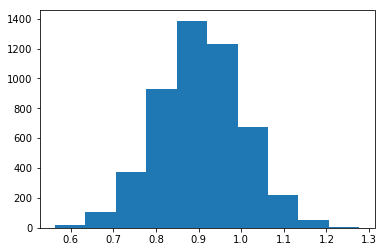

In [53]:
plt.hist(trace['alpha'])

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 0.29530249,  0.39530249,  0.49530249,  0.59530249,  0.69530249,
         0.79530249,  0.89530249,  0.99530249,  1.09530249,  1.19530249,
         1.29530249]),
 <a list of 10 Patch objects>)

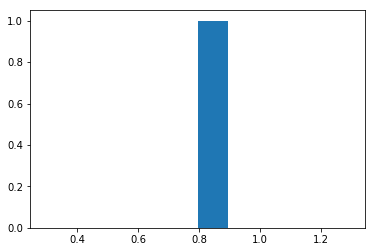

In [54]:
plt.hist(trace['beta'][0][0])

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 1.66123701,  1.76123701,  1.86123701,  1.96123701,  2.06123701,
         2.16123701,  2.26123701,  2.36123701,  2.46123701,  2.56123701,
         2.66123701]),
 <a list of 10 Patch objects>)

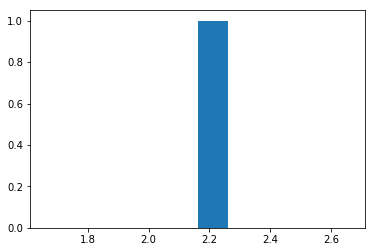

In [55]:
plt.hist(trace['beta'][0][1])

# Posterior analysis

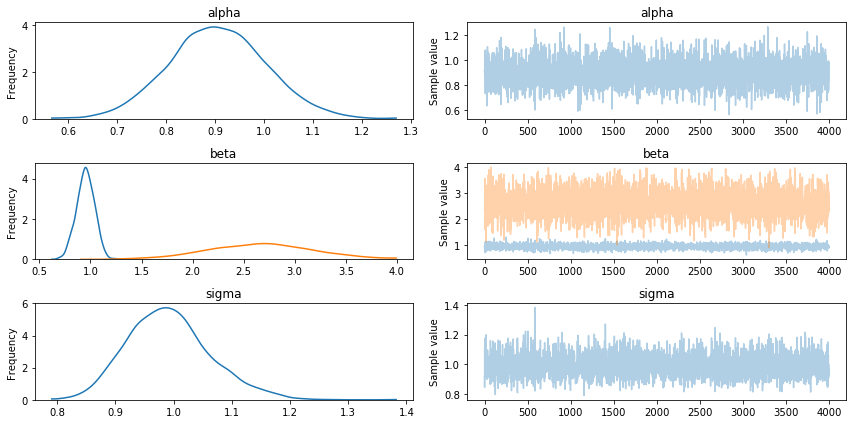

In [56]:
_ = pm.traceplot(trace[1000:])


In [57]:
DF=pm.trace_to_dataframe(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1168abe48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116f7f668>]], dtype=object)

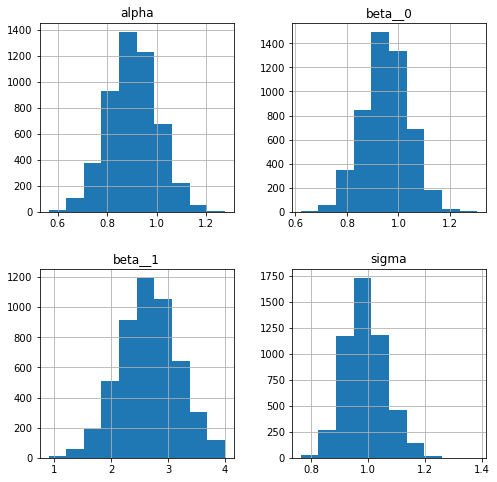

In [58]:
DF.hist(figsize=(8,8))

In [59]:
DF.describe()

,alpha,beta__0,beta__1,sigma
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.904714,0.951772,2.663503,0.991073
std,0.100232,0.088583,0.511206,0.070568
min,0.562812,0.620981,0.903936,0.764112
25%,0.838597,0.894276,2.312163,0.941198
50%,0.904242,0.952428,2.666556,0.987295
75%,0.971186,1.012575,3.005024,1.033960
max,1.277038,1.305962,3.999671,1.382410
